# Прогнозирование температуры звезды

Нам пришла задача от обсерватории «Небо на ладони»: нужно придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

Работа включает в себя:
 - Знакомство с данными
 - Анализ и предобработка данных
 - Построение базовой нейросети
 - Улучшение нейросети
 - Выводы

## Загружаем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns #библиотеки для предобработки

!pip install scikit-learn==1.2.1

from math import ceil, sqrt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error #библиотеки для ML

import torch
import torch.nn as nn #библиотеки НС

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## Предобработка и анализ данных

In [2]:
data = pd.read_csv('/datasets/6_class.csv')

In [3]:
def prepare(df): #фунция предобработки данных
    display(df.head())
    display(df.info())
    display(df.isna().sum())
    display(df.duplicated().sum())

In [4]:
prepare(data)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


None

Unnamed: 0                0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

0

In [5]:
data = data.iloc[:,1:] #нам не нужны нативные индексы-удаляем

In [6]:
data = data.rename(columns = 
                   {'Temperature (K)':'Temperature', 'Luminosity(L/Lo)': 'Luminosity', 
                    'Radius(R/Ro)': 'Radius', 'Absolute magnitude(Mv)': 'Absolute magnitude'}
                  ) #переименуем столбцы во избежания ошибок

In [7]:
data['Star color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [8]:
data['Star color'] = data['Star color'].str.lower()
data['Star color'] = data['Star color'].replace('blue white', 'blue-white')
data['Star color'] = data['Star color'].replace(['yellow-white', 'yellowish white'], 'white-yellow')
data['Star color'] = data['Star color'].replace('whitish', 'white')
data['Star color'] = data['Star color'].replace(['pale yellow orange', 'orange-red'], 'orange')
data['Star color'] = data['Star color'].str.strip(to_strip = None) #заменим названия

In [9]:
def boxplot_df(column_list, df): # функция для построения диаграммы размаха
    for column in column_list:
        df.boxplot(column=column)
        plt.title(f'Диаграмма размаха на столбце {column}')
        plt.show()
        df[column].plot(kind='hist', bins=100, grid=True)
        plt.title(f'Гистограмма на столбце {column}')
        plt.xlabel(column)
        plt.ylabel('Кол-во наблюдений')
        plt.show()

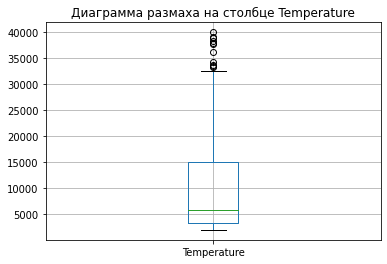

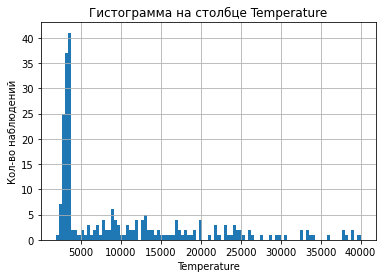

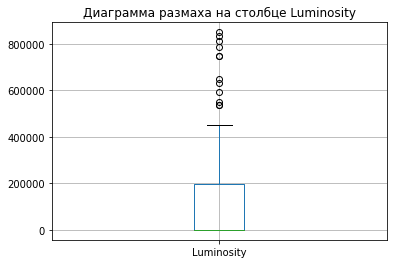

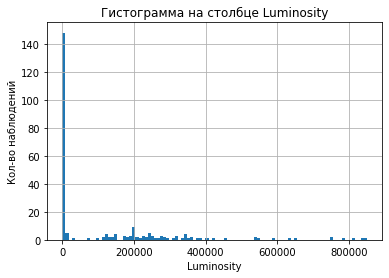

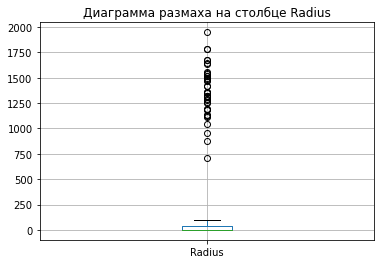

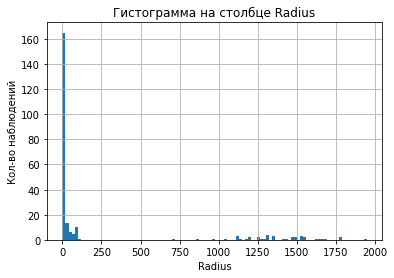

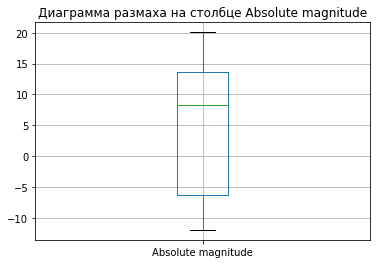

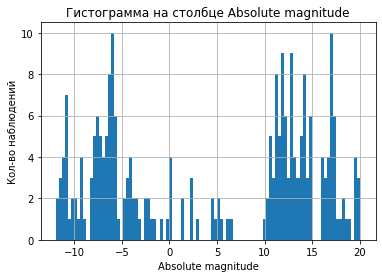

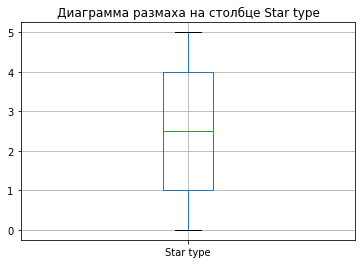

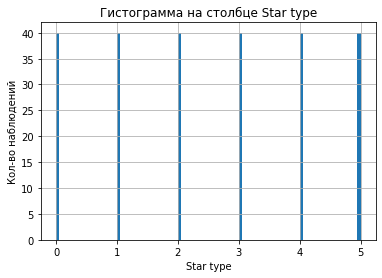

In [10]:
boxplot_df(['Temperature', 'Luminosity', 'Radius', 'Absolute magnitude', 'Star type'], data)

In [11]:
data.describe() #метрики по таблице

,Temperature,Luminosity,Radius,Absolute magnitude,Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Вывод: наш датасет невелик, поэтому имеющиеся выбросы удалять нецелесообразно.. Но если оценить данные по столбцам, можно сделать вывод, что были неявные дубликаты в названии цветов звезд, мы их заменили. В столбцах "Абсолютная звёздная величина" выбросов не замечено. По остальным столбцам медианное значение приближено к истиной медиане, поэтому никаких правок я бы не вносила ссылаясь на небольшой датасет.

## Построение базовой нейронной сети

### Подготовка данных для НС

In [12]:
num_cols = ['Luminosity','Radius','Absolute magnitude'] #числовые признаки
cat_cols = ['Star type', 'Star color'] #категориальные признаки
target = ['Temperature'] #целевой признак
x = data.drop(target, axis = 1).copy()
y = data[target].copy()

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3214)

In [14]:
for i in [x_train, x_test, y_train, y_test]:
    i.reset_index(drop=True, inplace=True)

In [15]:
OHE = OneHotEncoder(sparse=False, drop = 'first', handle_unknown = 'error') #преобразование категориальных данных методом OHE

x_train_cat = pd.DataFrame(OHE.fit_transform(x_train.loc[:,cat_cols]))
x_train_cat.columns = OHE.get_feature_names_out(cat_cols)
x_train.drop(cat_cols, axis = 1, inplace = True)
x_train = pd.concat([x_train, x_train_cat], axis = 1)

x_test_cat = pd.DataFrame(OHE.transform(x_test.loc[:,cat_cols]))
x_test_cat.columns = OHE.get_feature_names_out(cat_cols)
x_test.drop(cat_cols, axis = 1, inplace = True)
x_test = pd.concat([x_test, x_test_cat], axis = 1)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:
scaler = StandardScaler() #стандартизация числовых данных

x_train[num_cols] = scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])

In [17]:
x_train.head()

,Luminosity,Radius,Absolute magnitude,Star type_1,Star type_2,Star type_3,Star type_4,Star type_5,Star color_blue white,Star color_blue-white,Star color_orange,Star color_red,Star color_white,Star color_white-yellow,Star color_yellowish
0,-0.627498,-0.440475,-0.145987,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.496468,2.230756,-1.387146,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.627506,-0.442579,1.477650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.627506,-0.442030,0.756244,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.627506,-0.442717,0.754351,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [18]:
x_test.head()

,Luminosity,Radius,Absolute magnitude,Star type_1,Star type_2,Star type_3,Star type_4,Star type_5,Star color_blue white,Star color_blue-white,Star color_orange,Star color_red,Star color_white,Star color_white-yellow,Star color_yellowish
0,-0.627506,-0.442718,0.774232,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,3.016587,3.491780,-1.400400,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.627503,-0.440899,0.145605,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.627506,-0.441263,1.022274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.627506,-0.442186,0.790326,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Построение НС

In [19]:
x_train = torch.FloatTensor(x_train.values) #переменные должны быть тензорами
x_test  = torch.FloatTensor(x_test.values)
y_train  = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [20]:
n_in_neurons = 15 #задаем послойно количество нейронов, произвольно
n_hidden_neurons_1 = 50
n_hidden_neurons_2 = 30
n_out_neurons = 1

In [21]:
class Model(nn.Module): #создаем класс
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()


    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)

        
        return x         

In [22]:
net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons) 
#создаем модель, включающую нейроны, функцию потерь, оптимизатор

loss=nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer_1 = torch.optim.RMSprop(net.parameters(), lr=1e-3)
optimizer_2 = torch.optim.Adamax(net.parameters(), lr=1e-2)

In [23]:
def cross_val_score_(model, x_train, y_train, optim, num_epochs=250, batch_size=6, k=4, loss=nn.MSELoss()):
    #Функция для кросс-валидации нейронной сети
    num_of_batches = ceil(len(x_train)/batch_size) # батчи
    num_of_valid = len(x_train)//k 
    all_scores = []
    
    for i in range(k): 
        print('processing fold #', i+1, end='  ')
        
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
            
        valid_data = x_train[i*num_of_valid: (i+1)*num_of_valid]
        valid_targets = y_train[i*num_of_valid: (i+1)*num_of_valid]
        
        train_data_= np.concatenate([x_train[:i*num_of_valid], x_train[(i+1)*num_of_valid:]], axis = 0)
        train_target_ = np.concatenate([y_train[:i*num_of_valid], y_train[(i+1)*num_of_valid:]], axis = 0)
        
        
        valid_data = torch.FloatTensor(valid_data) #создаем из полученных переменных тензоры
        valid_targets = torch.FloatTensor(valid_targets)
        train_data_ = torch.FloatTensor(train_data_)
        train_target_ = torch.FloatTensor(train_target_)
        
        for epoch in range(num_epochs):
            order = np.random.permutation(len(train_data_))
            for batch_idx in range(num_of_batches):
                start_index = batch_idx * batch_size 
                optim.zero_grad() #обнуляем градиаенты
                
               
                batch_indexes = order[start_index:start_index+batch_size]
                x_batch = train_data_[batch_indexes]
                y_batch = train_target_[batch_indexes]
                
                preds = net.forward(x_batch).flatten() #вычисляем предсказания
                loss_value = loss(preds, y_batch.flatten()) 
                loss_value.backward()
                optim.step()
                
            if epoch == num_epochs-1: #выводим на экран по эпохам результаты расчетов
                model.eval()
                val_preds = model.forward(valid_data)
                RMSE_loss = torch.sqrt(loss(valid_targets, val_preds))
                all_scores.append(RMSE_loss)
                print('RMSE метрика =', float(RMSE_loss))
    print('Средняя RMSE метрика =', int(sum(all_scores)/len(all_scores)),  '\n')
    return

In [24]:
x = [optimizer, optimizer_1, optimizer_2]

for i in x: #применяем функции с разными оптимизаторами
    print(i)
    cross_val_score_(net, x_train, y_train, i)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 5879.142578125
processing fold # 2  RMSE метрика = 16192.5771484375
processing fold # 3  RMSE метрика = 11712.4326171875
processing fold # 4  RMSE метрика = 14440.392578125
Средняя RMSE метрика = 12056 

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 6016.591796875
processing fold # 2  RMSE метрика = 7071.54833984375
processing fold # 3  RMSE метрика = 5560.9287109375
processing fold # 4  RMSE метрика = 14440.392578125
Средняя RMSE метрика = 8272 

Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
processing fold # 1  RMSE метрика = 5939.17138671875
processing fold # 2  RMSE метрика = 5434.8310546875
processing fold # 3  RMSE метрика = 5381.56396484375
processing fo

In [25]:
def neyron(model, x_train, y_train, optim, num_epochs = 250, batch_size = 6): 
    
    #Функция для обучения НС
    
    num_batches = ceil(len(x_train)/batch_size)
    for epoch in range(num_epochs):
        order = np.random.permutation(len(x_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size 
            optim.zero_grad() 
        
            batch_indexes = order[start_index:start_index+batch_size] 
            x_batch = x_train[batch_indexes]
            y_batch = y_train[batch_indexes]
        
            preds = model.forward(x_batch).flatten() 
            loss_value = loss(preds, y_batch.flatten())
            loss_value.backward()
            optim.step()
    return  model

In [26]:
net = neyron(net, x_train, y_train, optimizer_2) #обучаем модель

In [27]:
net.eval()
test_preds = net.forward(x_test)
print('RMSE НС на тестовой выборке = ', int(torch.sqrt(loss(y_test, test_preds))))

RMSE НС на тестовой выборке =  12071


In [28]:
def double_plot(target, preds, width = 0.3): #строим график "Факт-прогноз"
    
    y1 = target.numpy().reshape([-1])
    y2 = preds.reshape([-1]).detach().numpy()
    x = np.arange(len(y1))
    
    fig,ax = plt.subplots()
    f = ax.bar(x - width/2, y1, width, label = 'Факт')
    f1 = ax.bar(x + width/2, y2, width, label = 'Прогноз')
    
    ax.set_title('Факт-Прогноз')
    ax.set_xticks(x)
    ax.set_xlabel('Номер звезды в таблице данных')
    ax.set_ylabel('Температура звезды')
    
    fig.set_figwidth(17)
    fig.set_figheight(10)
    ax.legend();

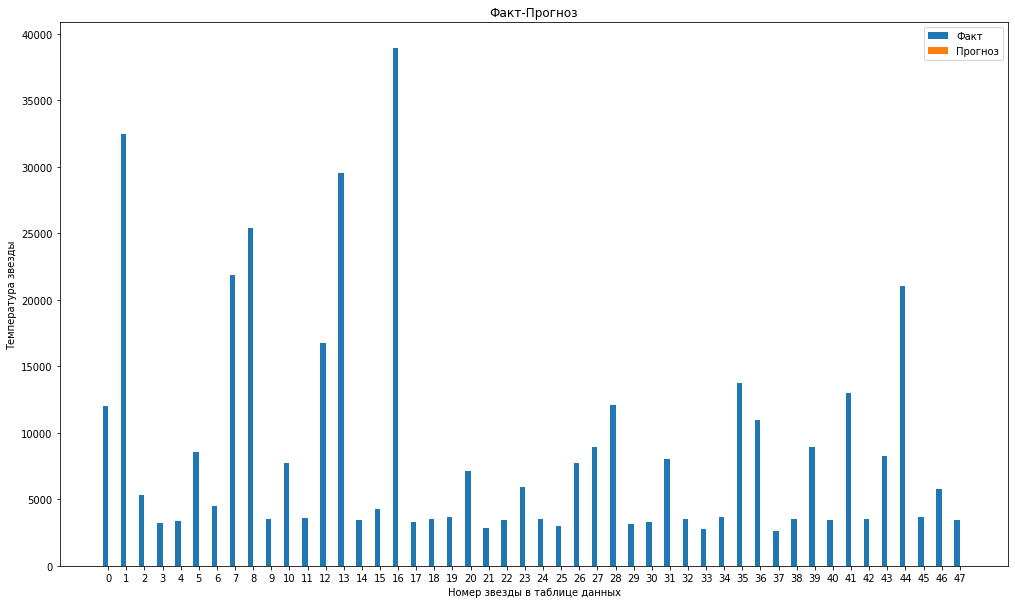

In [29]:
double_plot(y_test, test_preds)

Вывод: нейронная сеть показывает хороший результат с оптимизатором Adamax, его мы и будем применять и тюнить на следующем этапе. 

## Улучшение нейронной сети

In [30]:
class Model_1(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
            super(Model_1, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.dp2 = nn.Dropout(p=0.5)
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            self.act3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        
        return x

In [31]:
class Model_2(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
            super(Model_2, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.bn1 = nn.Dropout(p=0.7)
            self.act1 = nn.ReLU()
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
            self.dp2 = nn.Dropout(p=0.2)
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            self.act3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        x = self.act3(x)
        
        return x

In [32]:
net_1 = Model_1(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons) #вызываем модель

loss = nn.MSELoss() #задаем функцию потерь

optimizer_2 = torch.optim.Adamax(net_1.parameters(), lr=1e-2)

In [33]:
net_2 = Model_2(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons) #вызываем модель

loss = nn.MSELoss() #задаем функцию потерь

optimizer_2 = torch.optim.Adamax(net_2.parameters(), lr=1e-2)

In [34]:
net_1 = neyron(net_1, x_train, y_train, optimizer_2)

In [35]:
net_2 = neyron(net_2, x_train, y_train, optimizer_2)

In [36]:
net_1.eval()
test_preds_1 = net_1.forward(x_test)
print('RMSE НС на тестовой выборке = ', int(torch.sqrt(loss(y_test, test_preds_1))))

RMSE НС на тестовой выборке =  12071


In [37]:
net_2.eval()
test_preds_2 = net_2.forward(x_test)
print('RMSE НС на тестовой выборке = ', int(torch.sqrt(loss(y_test, test_preds_2))))

RMSE НС на тестовой выборке =  3912


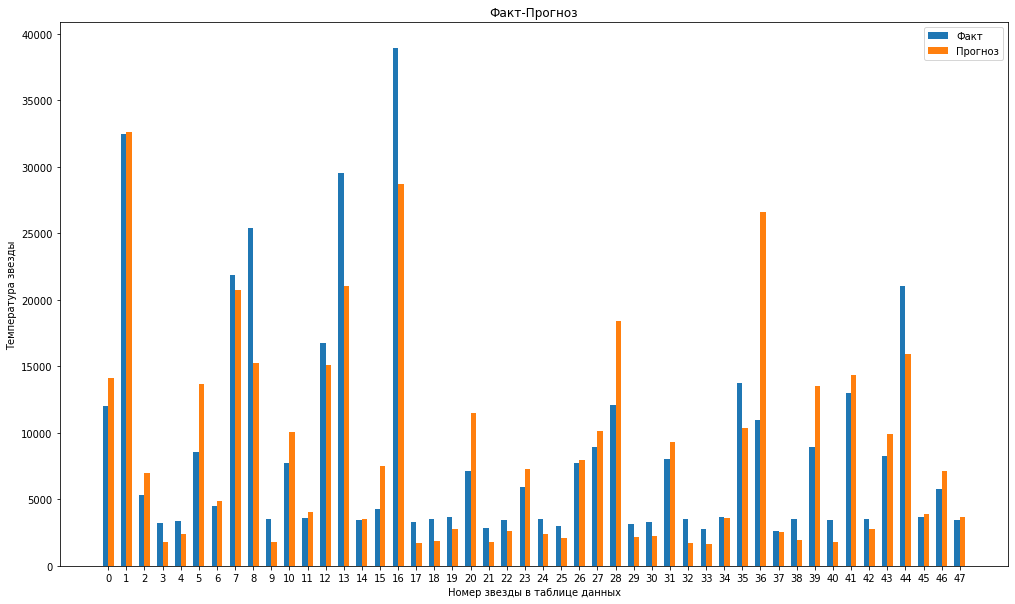

In [38]:
double_plot(y_test, test_preds_2) #строим график

## Выводы

В этом проекте мы разработали нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

В ходе работы мы проанализировали исходные данные и подготовили их к работе. Разделили данные на выборки, стандартизировали и преобразовали методом OHE.

Исследовали базовые архитектуры нейронных сетей из 1, 2 и 3 слоёв с разными функциями активациями. Оценили их эффективность по метрике RMSE. А также проэксперементировали с улучшением их с помощью методов BatchNorm1d и Dropout, в результате чего получили:

После применения наилучшего оптимизатора из первой части в совокупности с BatchNorm1d и Dropout метрика улучшилась, поэтому рекомендуемая мною модель, та что содержит следующие параметры:

 - Dropout-1 p=0.7
 - Dropout-2 p=0.2
 - BatchNorm1d -2
 - выходная функция ReLU

